In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"


In [2]:
import threadpoolctl
threadpoolctl._THREADPOOL_INFO_AVAILABLE = True


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))





In [8]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [9]:
import os
os.getcwd()


'c:\\Users\\HP\\Github_Repo\\Customer_segmentation'

In [10]:
data = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**From the above output, we can conclude and note that:**

* There are missing values in income
* Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime
* There are some categorical features in our data frame; as there are some features in dtype: object). So we will need to encode them into numeric forms later. 

First of all, for the missing values, I am simply going to drop the rows that have missing income values. 

In [12]:
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In the next step, I am going to create a feature out of **"Dt_Customer"** that indicates the number of days a customer is registered in the firm's database. However, in order to keep it simple, I am taking this value relative to the most recent customer in the record. 

Thus to get the values I must check the newest and oldest recorded dates. 

In [13]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True)

dates = []
for i in data["Dt_Customer"]: 
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))


The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


Creating a feature **("Customer_For")** of the number of days the customers started to shop in the store relative to the last recorded date

In [14]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

Now we will be exploring the unique values in the categorical features to get a clear idea of the data.  

In [15]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


**In the next bit, I will be performing the following steps to engineer some new features:**

* Extract the **"Age"** of a customer by the **"Year_Birth"** indicating the birth year of the respective person.
* Create another feature **"Spent"** indicating the total amount spent by the customer in various categories over the span of two years.
* Create another feature **"Living_With"** out of **"Marital_Status"** to extract the living situation of couples.
* Create a feature **"Children"** to indicate total children in a household that is, kids and teenagers.
* To get further clarity of household, Creating feature indicating **"Family_Size"**
* Create a feature **"Is_Parent"** to indicate parenthood status
* Lastly, I will create three categories in the **"Education"** by simplifying its value counts.
* Dropping some of the redundant features

In [16]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [17]:
data["Customer_For"].head()

0    57283200000000000
1     9763200000000000
2    26956800000000000
3    12009600000000000
4    13910400000000000
Name: Customer_For, dtype: int64

In [18]:
data[['Income','Recency','Wines','Fruits','Meat','Fish','Sweets','Gold']].head()

,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold
0,58138.0,58,635,88,546,172,88,88
1,46344.0,38,11,1,6,2,1,6
2,71613.0,26,426,49,127,111,21,42
3,26646.0,26,11,4,20,10,3,5
4,58293.0,94,173,43,118,46,27,15


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   int64  
 3   Teenhome             2216 non-null   int64  
 4   Recency              2216 non-null   int64  
 5   Wines                2216 non-null   int64  
 6   Fruits               2216 non-null   int64  
 7   Meat                 2216 non-null   int64  
 8   Fish                 2216 non-null   int64  
 9   Sweets               2216 non-null   int64  
 10  Gold                 2216 non-null   int64  
 11  NumDealsPurchases    2216 non-null   int64  
 12  NumWebPurchases      2216 non-null   int64  
 13  NumCatalogPurchases  2216 non-null   int64  
 14  NumStorePurchases    2216 non-null   int64  
 15  NumWebVisitsMonth    2216 non-null   int64 

Now that we have some new features let's have a look at the data's stats. 

The above stats show some discrepancies in mean Income and Age and max Income and age.

Do note that  max-age is 128 years, As I calculated the age that would be today (i.e. 2021) and the data is old.

I must take a look at the broader view of the data. 
I will plot some of the selected features.

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x200 with 0 Axes>

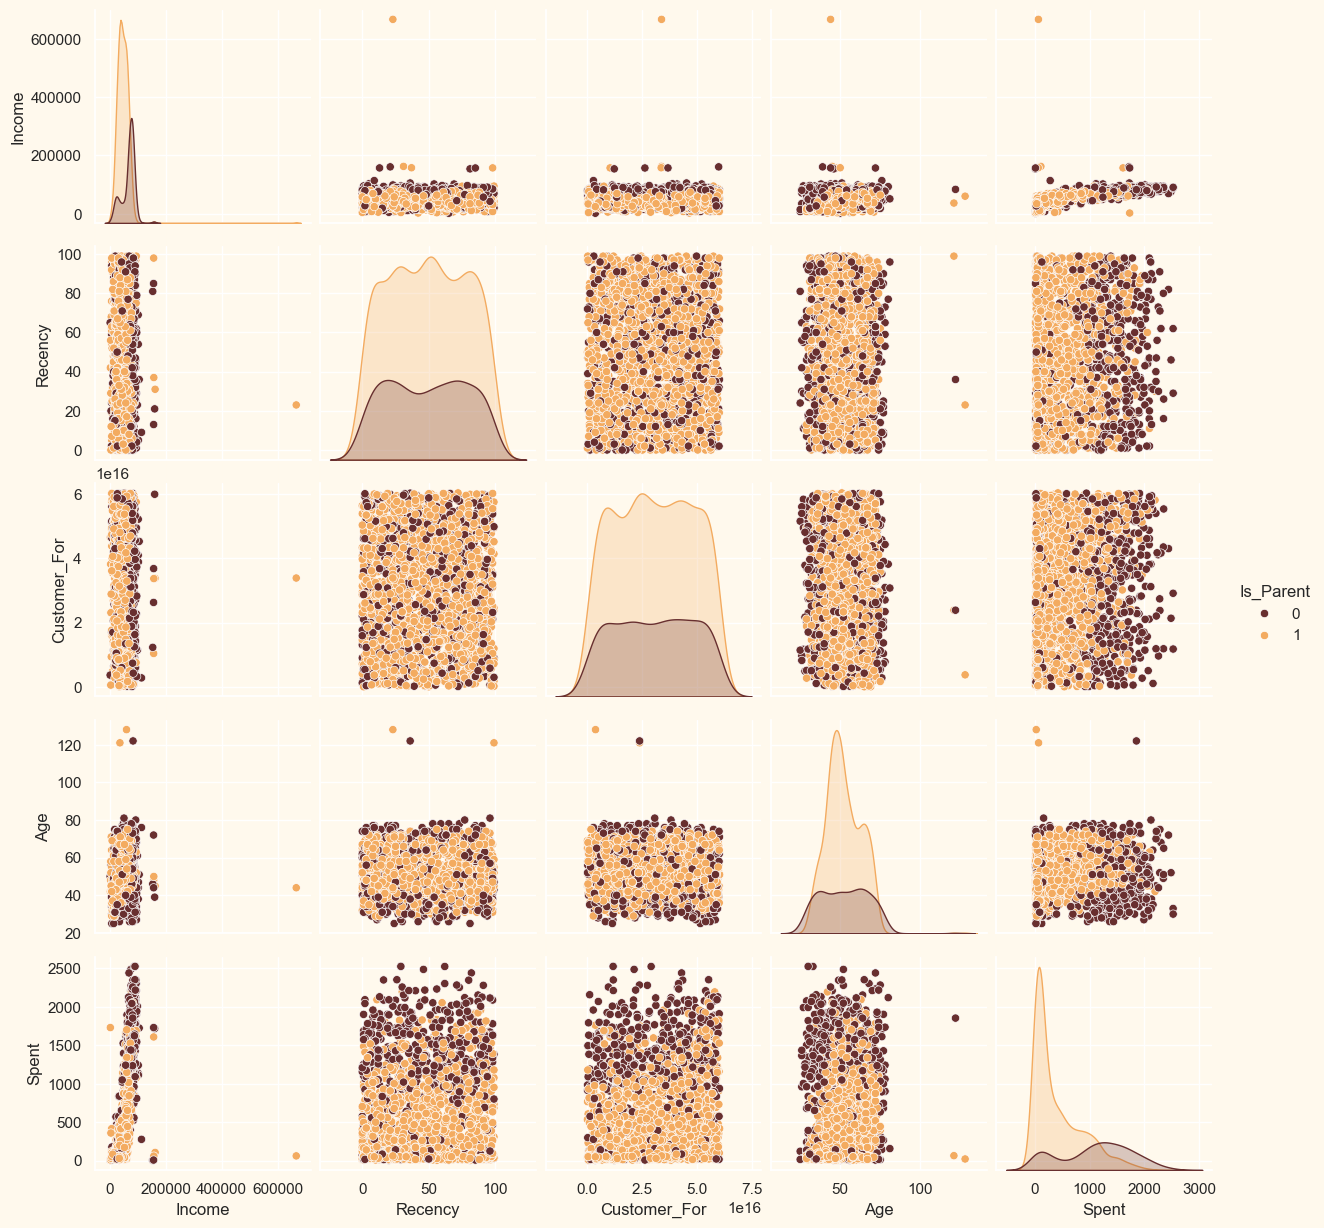

In [20]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED" ,"figure.figsize": (8, 2)})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

Clearly, there are a few outliers in the Income and Age features. 
I will be deleting the outliers in the data. 

In [21]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


Next, let us look at the correlation amongst the features. 
(Excluding the categorical attributes at this point)

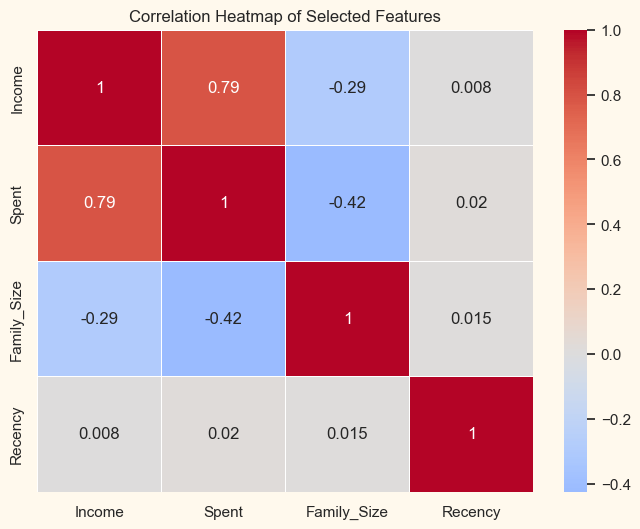

In [22]:
#correlation matrix
# Selecting only numeric columns
import seaborn as sns
import matplotlib.pyplot as plt
numeric_data = data.select_dtypes(include=['number'])
# List of important features
important_features = ['Income', 'Spent', 'Family_Size', 'Recency']

# Select only the important features from the numeric data
filtered_corr = numeric_data[important_features].corr()

# Plotting the filtered correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()



In [23]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [24]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [25]:
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
ds.info()
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   int64  
 1   Income               2212 non-null   float64
 2   Kidhome              2212 non-null   int64  
 3   Teenhome             2212 non-null   int64  
 4   Recency              2212 non-null   int64  
 5   Wines                2212 non-null   int64  
 6   Fruits               2212 non-null   int64  
 7   Meat                 2212 non-null   int64  
 8   Fish                 2212 non-null   int64  
 9   Sweets               2212 non-null   int64  
 10  Gold                 2212 non-null   int64  
 11  NumDealsPurchases    2212 non-null   int64  
 12  NumWebPurchases      2212 non-null   int64  
 13  NumCatalogPurchases  2212 non-null   int64  
 14  NumStorePurchases    2212 non-null   int64  
 15  NumWebVisitsMonth    2212 non-null   int64 

In [26]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


In [27]:
scaled_ds.isnull().sum()

Education              0
Income                 0
Kidhome                0
Teenhome               0
Recency                0
Wines                  0
Fruits                 0
Meat                   0
Fish                   0
Sweets                 0
Gold                   0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
Customer_For           0
Age                    0
Spent                  0
Living_With            0
Children               0
Family_Size            0
Is_Parent              0
dtype: int64

In [28]:
scaled_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   float64
 1   Income               2212 non-null   float64
 2   Kidhome              2212 non-null   float64
 3   Teenhome             2212 non-null   float64
 4   Recency              2212 non-null   float64
 5   Wines                2212 non-null   float64
 6   Fruits               2212 non-null   float64
 7   Meat                 2212 non-null   float64
 8   Fish                 2212 non-null   float64
 9   Sweets               2212 non-null   float64
 10  Gold                 2212 non-null   float64
 11  NumDealsPurchases    2212 non-null   float64
 12  NumWebPurchases      2212 non-null   float64
 13  NumCatalogPurchases  2212 non-null   float64
 14  NumStorePurchases    2212 non-null   float64
 15  NumWebVisitsMonth    2212 non-null   f

In [29]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Impute Income with mean
imputer = SimpleImputer(strategy='mean')
scaled_ds = pd.DataFrame(imputer.fit_transform(scaled_ds), columns=scaled_ds.columns)


In [30]:
#Initiating PCA to reduce dimentions
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,2.569775e-17,2.878602,-5.978124,-2.539470,-0.781595,2.386380,7.452915
col2,2212.0,5.139550e-17,1.709469,-4.194757,-1.323929,-0.173721,1.234851,6.168189
col3,2212.0,-1.606109e-17,1.231687,-3.625248,-0.853713,-0.050842,0.863974,6.750458


In [31]:
scaled_ds.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


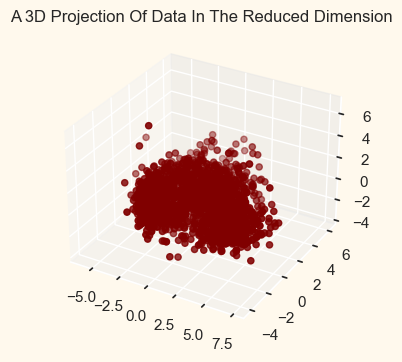

In [32]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

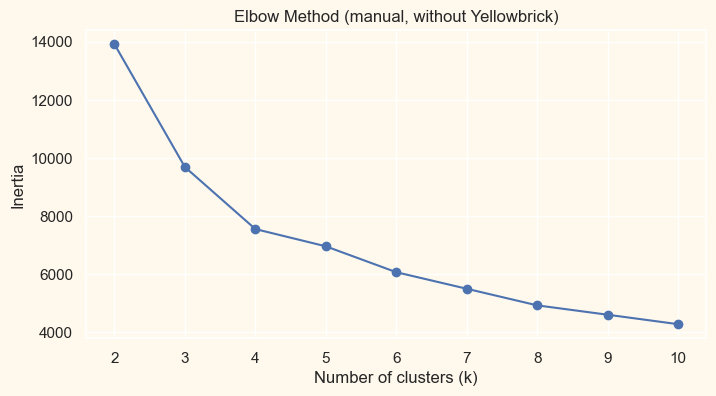

In [33]:
# Manual Elbow Method (replaces Yellowbrick)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []
K = range(2, 11)  # try 2 to 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(PCA_ds)   # X = your scaled dataset
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertias, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method (manual, without Yellowbrick)')
plt.grid(True)
plt.show()


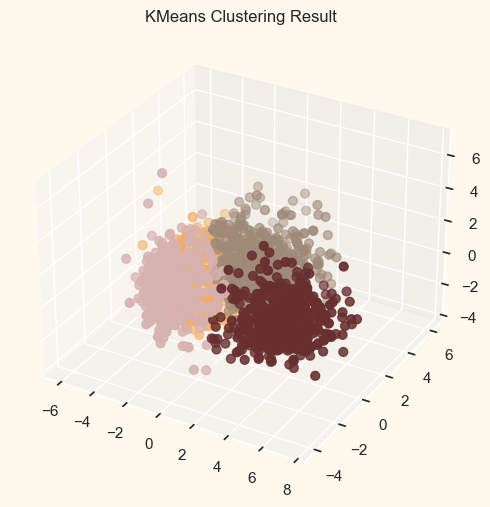

In [34]:
from sklearn.cluster import KMeans

# Fit the KMeans model
kmeans = KMeans(n_clusters=4, random_state=42)
yhat_kmeans = kmeans.fit_predict(PCA_ds)

# Add clusters to the dataset
PCA_ds["Clusters"] = yhat_kmeans
data["Clusters"] = yhat_kmeans


# Plotting the clusters (same as your existing code)
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111, projection='3d')
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap=cmap)
ax.set_title("KMeans Clustering Result")
plt.show()

In [35]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Evaluate clustering quality on the PCA-transformed features
pca_features = PCA_ds[['col1', 'col2', 'col3']]
silhouette = silhouette_score(pca_features, yhat_kmeans)
dbi = davies_bouldin_score(pca_features, yhat_kmeans)

print(f"Silhouette score (higher is better): {silhouette:.3f}")
print(f"Davies-Bouldin index (lower is better): {dbi:.3f}")


Silhouette score (higher is better): 0.373
Davies-Bouldin index (lower is better): 0.990


The above cell indicates that four will be an optimal number of clusters for this data. 
Next, we will be fitting the Agglomerative Clustering Model to get the final clusters. 

To examine the clusters formed let's have a look at the 3-D distribution of the clusters. 

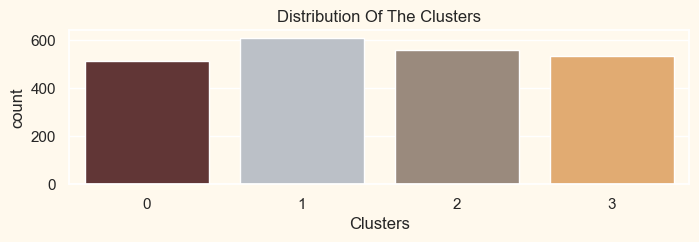

In [36]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

In [37]:

data["Clusters"] = yhat_kmeans

# Recommendation Model (revised: keeps only needed cols, ranks top-N, supports real-time)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Core columns used for clustering and similarity (match scaled_ds)
cluster_feature_cols = scaled_ds.columns.tolist()
product_cols = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
rec_features = ['Clusters'] + cluster_feature_cols

# Build recommendation frames (scaled for similarity, raw for uplift)
rec_data = data[rec_features].copy()
rec_scaler = StandardScaler()
rec_scaled = rec_data.copy()
rec_scaled[cluster_feature_cols] = rec_scaler.fit_transform(rec_scaled[cluster_feature_cols])

rec_centroids = rec_scaled.groupby('Clusters').mean()
cluster_product_means = data.groupby('Clusters')[product_cols].mean()

# Recommendation function (ranked uplift with similarity gate)
def recommend_products(customer_idx, similarity_threshold=0.4, top_n=3):
    feature_cols = [c for c in cluster_feature_cols if c not in product_cols]
    customer_features = rec_scaled.loc[[customer_idx], feature_cols].values
    cluster = int(rec_scaled.loc[customer_idx, 'Clusters'])
    centroid_features = rec_centroids.loc[cluster, feature_cols].values.reshape(1, -1)
    similarity = cosine_similarity(customer_features, centroid_features)[0][0]

    if similarity < similarity_threshold:
        return [], similarity

    uplift = (cluster_product_means.loc[cluster] - data.loc[customer_idx, product_cols])
    uplift = uplift[uplift > 0].sort_values(ascending=False)
    top_products = list(uplift.head(top_n).index)
    return top_products, similarity

# Generate recommendations (only necessary columns)
recommendations = []
for idx in rec_scaled.index:
    top_products, similarity = recommend_products(idx, similarity_threshold=0.4, top_n=3)
    recommendations.append({
        'Customer_Index': idx,
        'Clusters': int(data.loc[idx, 'Clusters']),
        'Recommended_Products': ", ".join(top_products) if top_products else "No uplift product",
        'Similarity_Score': similarity
    })

recommendations_with_clusters = pd.DataFrame(recommendations, columns=['Customer_Index', 'Clusters', 'Recommended_Products', 'Similarity_Score'])
print("Sample Recommendations (with Clusters):")
print(recommendations_with_clusters.head(10))
recommendations_with_clusters.to_csv('customer_recommendations.csv', index=False)
print("Recommendations saved to 'customer_recommendations.csv'")


Sample Recommendations (with Clusters):
   Customer_Index  Clusters Recommended_Products  Similarity_Score
0               0         0    No uplift product          0.640565
1               1         3    Wines, Meat, Gold          0.741340
2               2         0  Meat, Wines, Sweets          0.736314
3               3         1    Wines, Gold, Meat          0.743513
4               4         3    No uplift product          0.112429
5               5         2     Meat, Gold, Fish          0.655516
6               6         2    Wines, Gold, Meat          0.623134
7               7         1         Fish, Sweets          0.778059
8               8         1    Wines, Gold, Fish          0.807960
9               9         3    Wines, Meat, Fish          0.598257
Recommendations saved to 'customer_recommendations.csv'


In [38]:
# Real-time helper: assign cluster and get recommendations from user input
# Requires: scaler (clustering scaler), pca, kmeans, scaled_ds, data, product_cols, rec_scaler, rec_centroids, cluster_product_means

cluster_input_cols = scaled_ds.columns.tolist()


def recommend_for_new_customer(customer_dict, similarity_threshold=0.4, top_n=3):
    """
    customer_dict keys must cover cluster_input_cols.
    Returns cluster id, similarity, and top-N recommended products.
    """
    incoming = pd.DataFrame([customer_dict])
    incoming = incoming[cluster_input_cols]

    # Assign cluster using the existing clustering pipeline
    scaled_incoming = scaler.transform(incoming)
    pca_incoming = pca.transform(scaled_incoming)
    cluster = int(kmeans.predict(pca_incoming)[0])

    # Prepare for recommendation similarity
    rec_row = incoming.copy()
    rec_row.insert(0, 'Clusters', cluster)
    rec_row_scaled = rec_row.copy()
    rec_row_scaled[cluster_input_cols] = rec_scaler.transform(rec_row_scaled[cluster_input_cols])

    feature_cols = [c for c in cluster_input_cols if c not in product_cols]
    centroid_features = rec_centroids.loc[cluster, feature_cols].values.reshape(1, -1)
    similarity = cosine_similarity(rec_row_scaled[feature_cols], centroid_features)[0][0]

    if similarity < similarity_threshold:
        return {
            'Cluster': cluster,
            'Similarity_Score': similarity,
            'Recommended_Products': "No uplift product (similarity too low)"
        }

    uplift = (cluster_product_means.loc[cluster] - rec_row.loc[0, product_cols])
    uplift = uplift[uplift > 0].sort_values(ascending=False)
    top_products = list(uplift.head(top_n).index)

    return {
        'Cluster': cluster,
        'Similarity_Score': similarity,
        'Recommended_Products': ", ".join(top_products) if top_products else "No uplift product"
    }

# Example usage (replace values with real customer input):
# example_customer = {
#     'Education': 2, 'Income': 50000, 'Kidhome': 0, 'Teenhome': 0, 'Recency': 10,
#     'Wines': 200, 'Fruits': 20, 'Meat': 50, 'Fish': 10, 'Sweets': 5, 'Gold': 0,
#     'NumDealsPurchases': 2, 'NumWebPurchases': 5, 'NumCatalogPurchases': 1, 'NumStorePurchases': 3,
#     'NumWebVisitsMonth': 4, 'Customer_For': 400, 'Age': 40, 'Spent': 285,
#     'Living_With': 1, 'Children': 0, 'Family_Size': 2, 'Is_Parent': 0
# }
# recommend_for_new_customer(example_customer)



In [39]:
df=pd.read_csv("customer_recommendations.csv", sep="\t")


In [40]:
recommendations = pd.read_csv('customer_recommendations.csv')
#dataset_with_clusters = pd.read_csv('marketing_campaign_with_clusters.csv')
#merged = recommendations.merge(dataset_with_clusters[['Income','Spent', 'Recency', 'Family_Size']], left_index=True, right_index=True)
#print(merged.head(10))
#merged.to_csv('customer_recommendations.csv', index=False)

In [41]:
cluster_0_data = data[data['Clusters'] == 0]
cluster_1_data = data[data['Clusters'] == 1]
cluster_2_data = data[data['Clusters'] == 2]
cluster_3_data = data[data['Clusters'] == 3]

In [42]:
# Compute median and mode of Gold spending for Cluster 1
cluster_1_data = data[data['Clusters'] == 1]
gold_stats = {
    'Mean': cluster_1_data['Gold'].mean(),
    'Median': cluster_1_data['Gold'].median(),
    'Mode': cluster_1_data['Gold'].mode()[0]
}
print("Gold Spending Statistics for Cluster 1:")
print(gold_stats)

Gold Spending Statistics for Cluster 1:
{'Mean': np.float64(18.16393442622951), 'Median': np.float64(11.0), 'Mode': np.int64(3)}


In [43]:
# Compute average Income and Spent per cluster
cluster_profiles = data.groupby('Clusters')[['Income', 'Spent']].mean()
print("Cluster Profiles (Average Income and Spent):")
print(cluster_profiles)

Cluster Profiles (Average Income and Spent):
                Income        Spent
Clusters                           
0         75668.779297  1370.324219
1         30461.955738   102.495082
2         61797.330341   895.504488
3         43503.879925   150.756098


The clusters seem to be fairly distributed.

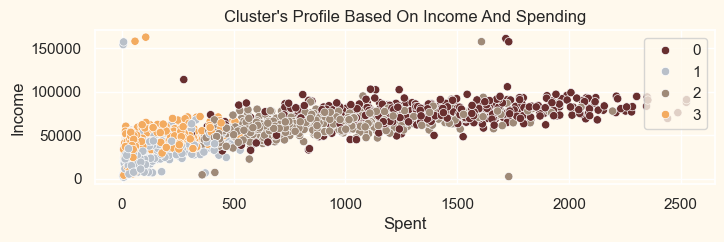

In [44]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

## Income vs Spending Plot – Cluster Interpretation

- **Group 0** (Dark Maroon): High spending & average income  
- **Group 1** (Light Blue): Low spending & low income  
- **Group 2** (Brownish Gray): Average income & moderate-to-high spending  
- **Group 3** (Orange): Low spending & low-to-mid income



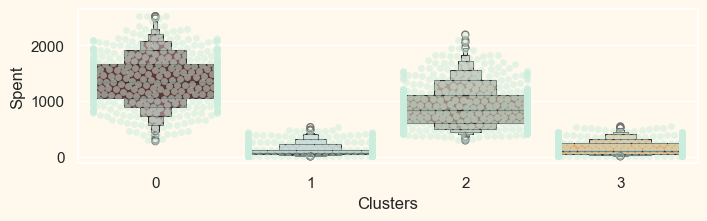

In [45]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()


From the above plot, it can be clearly seen that cluster 1 is our biggest set of customers closely followed by cluster 0.
We can explore what each cluster is spending on for the targeted marketing strategies.


Let us next explore how did our campaigns do in the past.

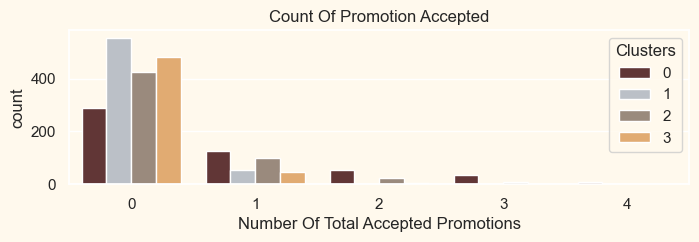

In [46]:
#Creating a feature to get a sum of accepted promotions 
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales. 


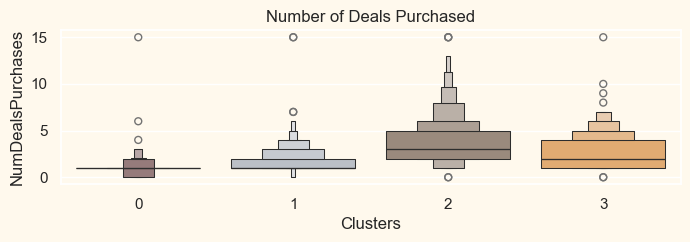

In [47]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

Unlike campaigns, the deals offered did well. It has best outcome with cluster 0 and cluster 3. 
However, our star customers cluster 1 are not much into the deals. 
Nothing seems to attract cluster 2 overwhelmingly 


<Figure size 1000x600 with 0 Axes>

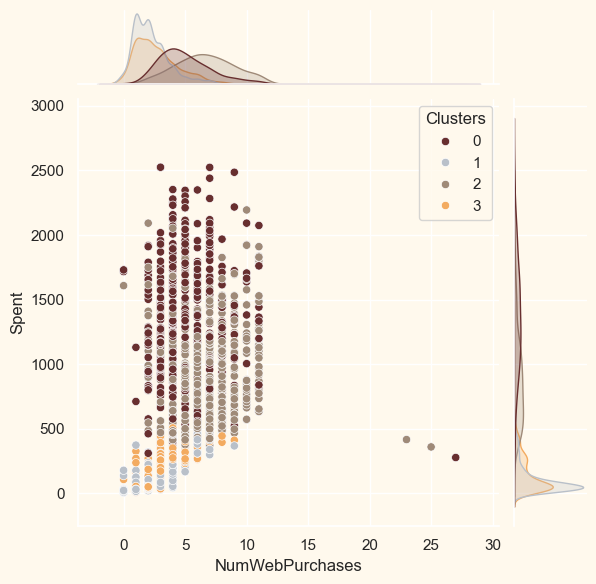

<Figure size 1000x600 with 0 Axes>

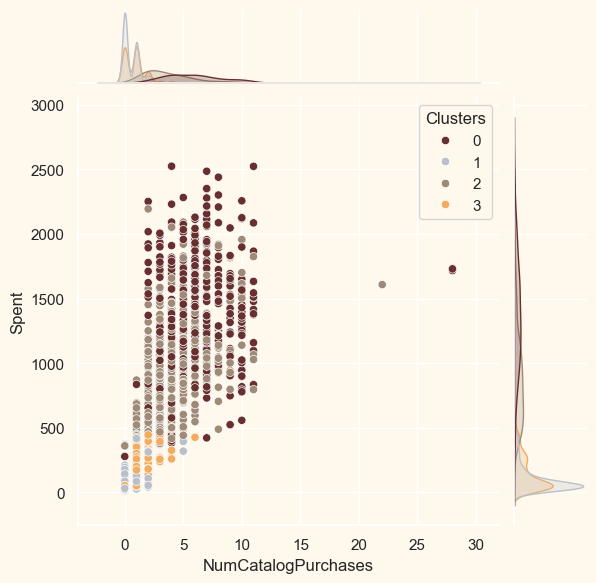

<Figure size 1000x600 with 0 Axes>

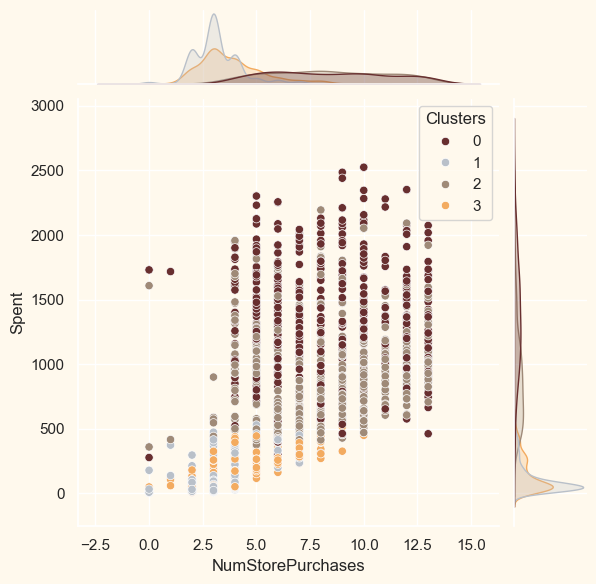

<Figure size 1000x600 with 0 Axes>

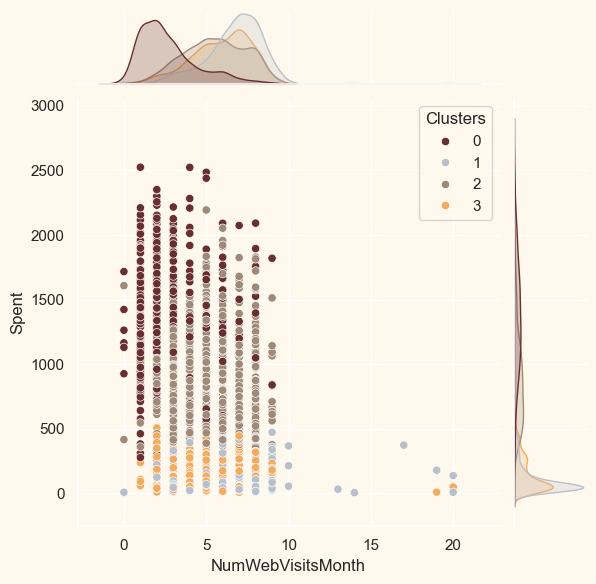

In [48]:
#for more details on the purchasing style 
Places =["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",  "NumWebVisitsMonth"] 

for i in Places:
    plt.figure(figsize=(10,6))
    sns.jointplot(x=data[i],y = data["Spent"],hue=data["Clusters"], palette= pal)
    plt.show()

In [49]:
cluster_summary = data.groupby('Clusters')['Spent'].mean().reset_index()

print(cluster_summary)


   Clusters        Spent
0         0  1370.324219
1         1   102.495082
2         2   895.504488
3         3   150.756098


In [50]:
import pickle

# Save the model
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

with open("scaler.pkl","wb") as f:
    pickle.dump(scaler,f)


In [51]:
# Later, to load it again
with open("kmeans_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

In [52]:
import joblib

# After fitting in your notebook:
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(pca, "models/pca.pkl")
joblib.dump(kmeans, "models/kmeans.pkl")
joblib.dump(rec_scaler, "models/rec_scaler.pkl")
joblib.dump(rec_centroids, "models/centroids.pkl")
joblib.dump(cluster_product_means, "models/cluster_product_means.pkl")

# Save recommendations CSV
recommendations_with_clusters.to_csv("customer_recommendations.csv", index=False)

# Also save your raw data with Clusters and product/features
data.to_csv("customer_segmentation_data.csv", index=False)